## Import libraries

In [1]:
import numpy as np  # Used for creating rating / indicator functions
import pyam  # Useful for storing climate / energy scenario data
import pandas as pd

from pandas_indexing import *

import data_shepherd as ds
from data_shepherd.utils import convert_unit
import datatoolbox as dt

import pycountry

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns


ca_colors = ['#95AD28','#2C8090','#F0280E','#F0CF1C','#1478B0','#59C954','#059E73','#945EB0','#383836','#828282','#C2C2C2']
ca_colors = sns.color_palette(ca_colors)
ca_colors

from matplotlib import rcParams
# rcParams['font.sans-serif'] = ['Lato']

sns.set_palette(ca_colors)

<IPython.core.display.Javascript object>

In [2]:
def cap_add(tech):
    return f"Capacity Additions|Electricity|{tech}"

def cap(tech):
    return f"Capacity|Electricity|{tech}"

def elec(tech=None):
    if tech is None:
        return "Secondary Energy|Electricity"
    else:
        return f"Secondary Energy|Electricity|{tech}"

## Load and process data 

In [3]:
df = pyam.IamDataFrame('../phaseI_1/REMIND_phaseI_1_2024-04-15_19.21.17.xlsx')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../phaseI_1/REMIND_phaseI_1_2024-04-15_19.21.17.xlsx


In [3]:
remind_raw = dt.findp(source='IKEA_phase2_bespokeREMIND_draft').as_pyam()
remind_shepherded = pyam.IamDataFrame('../data/processed/deepelec_v0_shepherded.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/processed/deepelec_v0_shepherded.csv


In [4]:
for unit in ['Mt CH4/yr','kt N2O/yr',"Mt CO2eq / yr","Mt CO2eq/yr"]:
    remind_shepherded.convert_unit(unit,"Mt CO2e / yr", inplace=True, context="AR4GWP100")

NameError: name 'remind_shepherded' is not defined

In [ ]:
remind_shepherded.filter(
    variable='Emissions',
    keep=False,
    inplace=True)

remind_shepherded.append(
    remind_shepherded
    .convert_unit('Mt CO2/yr','Mt CO2e / yr')
    .filter(model='IEA*',keep=False)
    .aggregate(
        'Emissions',
        [
            'Emissions|CO2',
            'Emissions|CH4',
            'Emissions|N2O',
            'Emissions|GHGAR4|Industrial Processes' #Is this what F-Gases are after shepherding Marie-Charlotte?
        ]),
    inplace=True
)

In [8]:
remind_shepherded.rename(
    region={'EARTH':'World'},
    inplace=True)

In [9]:
model_regions = ds.utils.RegionMapping.from_model('REMIND_2.1').iso_to_region.unique()

## Visualise data

### Emissions

(0.0, 55000.0)

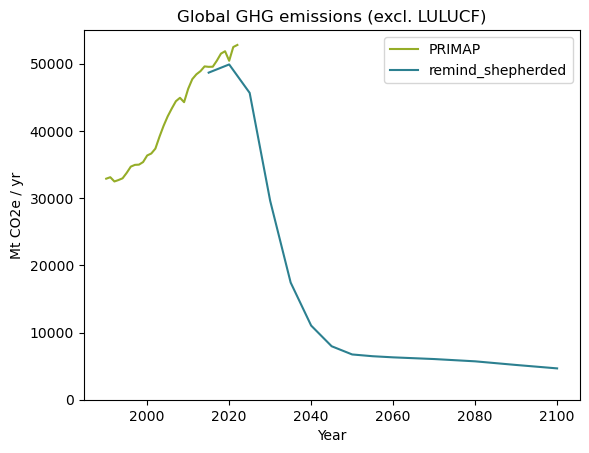

In [10]:
f, ax = plt.subplots()

remind_shepherded.filter(variable='Emissions',region='World').plot(ax=ax)
ax.set_title('Global GHG emissions (excl. LULUCF)')
ax.legend(['PRIMAP','remind_shepherded'])
ax.set_ylim([0,55000])

### Look at emissions reductions by gas

<Axes: title={'center': 'model: REMIND 3.2 scenario: SSP2EU-PkBudg500_v0 region: World'}, xlabel='Year'>

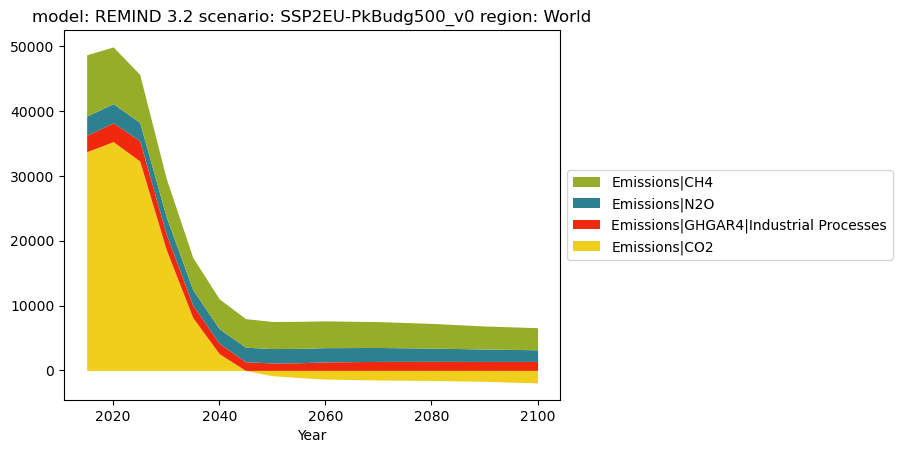

In [11]:
remind_shepherded.filter(
    variable=['Emissions|CO2','Emissions|CH4','Emissions|N2O','Emissions|GHGAR4|*'],
    region='World',
    model='REMIND 3.2').plot.stack(
    order=['Emissions|CH4','Emissions|N2O','Emissions|GHGAR4|Industrial Processes','Emissions|CO2'])

### Power sector

In [5]:
elec_vars = [
    elec(var) for var in [
        'Biomass|w/ CCS',
        'Biomass|w/o CCS',
        'Coal',
        'Gas',
        'Non-Biomass Renewables',
        #'Geothermal','Hydro','Wind','Solar', #These don't currently appear in the shepherded dataset
        'Nuclear',
        'Oil']]

In [6]:
color_map = dict(zip(
    elec_vars,
    [ca_colors[n] for n in [5,6,8,9,4,7,10]]
))
pyam.run_control().update({'color': {'variable': color_map}})

<Axes: title={'center': 'model: REMIND 3.2 scenario: SSP2EU-PkBudg500_v0 region: World'}, xlabel='Year', ylabel='EJ/yr'>

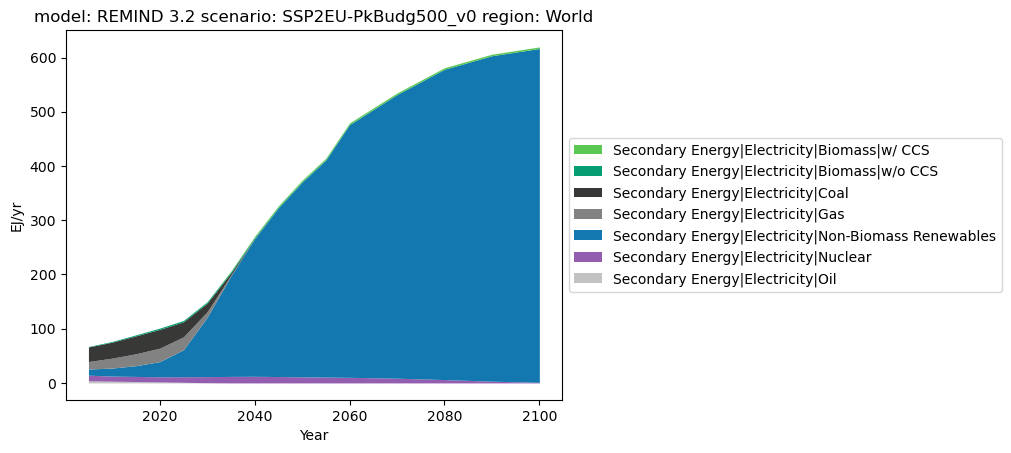

In [14]:
remind_shepherded.filter(
    model='REMIND 3.2',
    variable=elec_vars,
    region='World').plot.stack()

In [15]:
for var in elec_vars:
    remind_shepherded.divide(
        var,
        elec(),
        var+'|share',
        ignore_units='',
        append=True)

remind_shepherded.convert_unit('','%',factor=1e2,inplace=True)

In [7]:
for var in elec_vars:
    df.divide(
        var,
        elec(),
        var+'|share',
        ignore_units='',
        append=True)

df.convert_unit('','%',factor=1e2,inplace=True)

In [23]:
df.filter(variable=[elec('Coal|share')])

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : REMIND 3.3 (1)
 * scenario : SSP2EU-PkBudg500_cost_budget4_bionu, ... (2)
Timeseries data coordinates:
   region   : CAZ, CHA, EUR, IND, JPN, LAM, MEA, NEU, OAS, REF, ... World (13)
   variable : Secondary Energy|Electricity|Coal|share (1)
   unit     : % (1)
   year     : 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, ... 2100 (16)
Meta indicators:
   exclude (bool) False (1)

In [36]:
df.region

['CAZ',
 'CHA',
 'EUR',
 'IND',
 'JPN',
 'LAM',
 'MEA',
 'NEU',
 'OAS',
 'REF',
 'SSA',
 'USA',
 'World']

In [43]:
df.filter(
    variable = ['*Coal|share',], 
    region = ['CHA'], 
    year = [2030,2035,2040,2050], 
    scenario = '*year*'
).timeseries()

2030  \
model      scenario                         region variable                                unit             
REMIND 3.3 SSP2EU-PkBudg500_cost_year_bionu CHA    Secondary Energy|Electricity|Coal|share %     8.530297   

                                                                                                     2035  \
model      scenario                         region variable                                unit             
REMIND 3.3 SSP2EU-PkBudg500_cost_year_bionu CHA    Secondary Energy|Electricity|Coal|share %     1.872489   

                                                                                                     2040  \
model      scenario                         region variable                                unit             
REMIND 3.3 SSP2EU-PkBudg500_cost_year_bionu CHA    Secondary Energy|Electricity|Coal|share %     0.419726   

                                                                                                     2050  
model      scenario                         region variable                                unit            
REMIND 3.3 SSP2EU-PkBudg500_cost_year_bionu CHA    Secondary Energy|Electricity|Coal|share %     0.000224

In [52]:
df.filter(
    variable = ['*Gas|share',], 
    region = ['EUR', 'USA', 'JPN', 'CAZ'], 
    # year = [2030,2035,2040,2050], 
    # scenario = '*budget*'
).to_csv("V1_besploke_Gas_share_OECD.csv")

/Users/marie-charlottegeffray/opt/anaconda3/envs/cpt_generic/lib/python3.8/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/marie-charlottegeffray/opt/anaconda3/envs/cpt_generic/lib/python3.8/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/marie-charlottegeffray/opt/anaconda3/envs/cpt_generic/lib/python3.8/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/marie-charlottegeffray/opt/anaconda3/envs/cpt_generic/lib/python3.8/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/marie

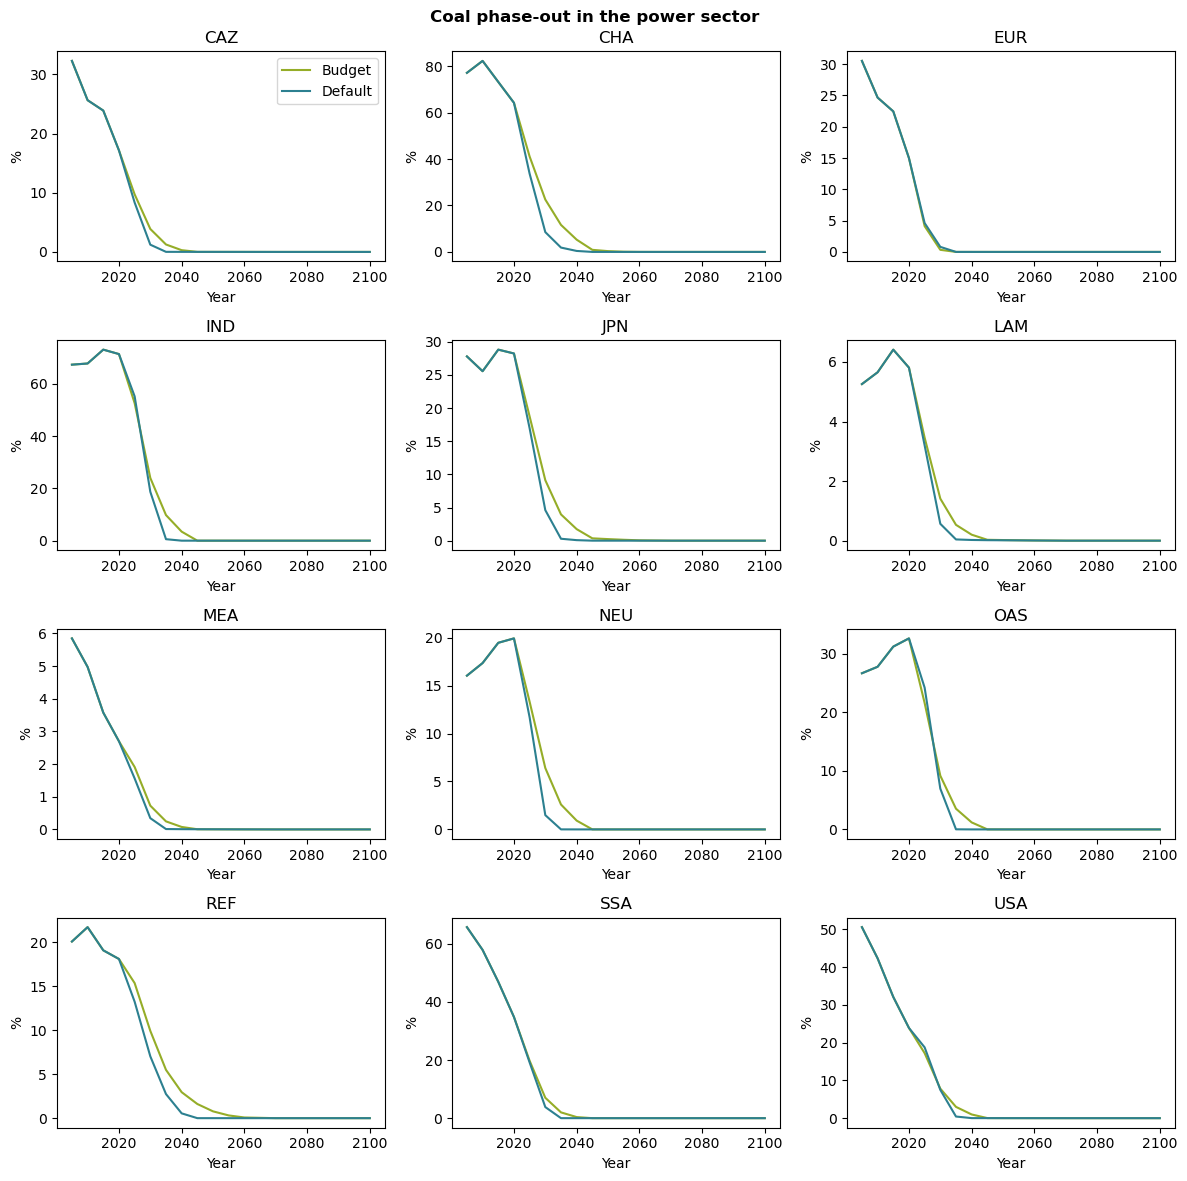

In [25]:
f, axes = plt.subplots(nrows=4,ncols=3,figsize=(12,12))

for count, ax in enumerate(axes.ravel()):
    (
        df
        .filter(variable=[elec('Coal|share')],region=df.region[count])
        # .convert_unit('EJ/yr','TWh / yr')
        .plot(ax=ax,color='scenario')
    )
    ax.set_title(df.region[count])
    ax.get_legend().remove()
    ax.axhline(y=0,color='k',lw=0)

axes[0,0].legend(['Budget','Default'])
f.suptitle('Coal phase-out in the power sector',
          fontweight='bold')
plt.tight_layout()
plt.savefig("../outputs/V1_Coal_phaseout.png")

Notes on coal phase-out:
- More ambitious in JPN and NEU and USA (total coal phase-out ideally)

Notes on gas phase-out:
- Gas in SSA is still odd

But otherwise pretty good

### Check Nuclear level

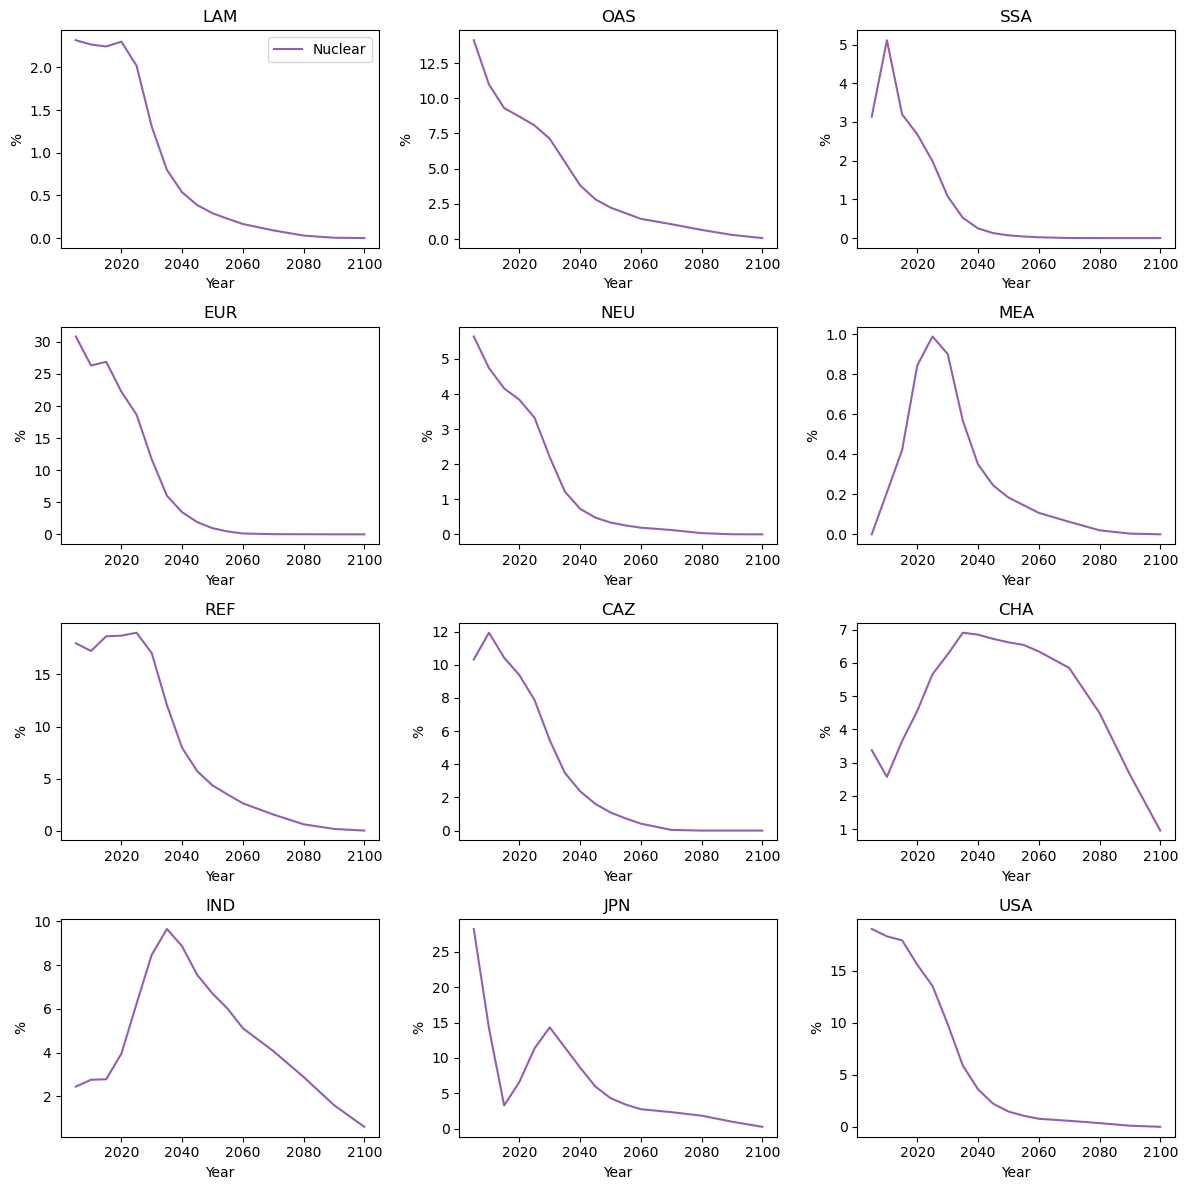

In [17]:
f, axes = plt.subplots(nrows=4,ncols=3,figsize=(12,12))

for count, ax in enumerate(axes.ravel()):
    (
        remind_shepherded
        .filter(variable=[elec('Nuclear|share')],region=model_regions[count],model='REMIND 3.2')
        # .convert_unit('EJ/yr','TWh / yr')
        .plot(ax=ax,color=ca_colors[7])
    )
    ax.set_title(model_regions[count])
    ax.get_legend().remove()

axes[0,0].legend(['Nuclear'])
plt.tight_layout()

### Biomass

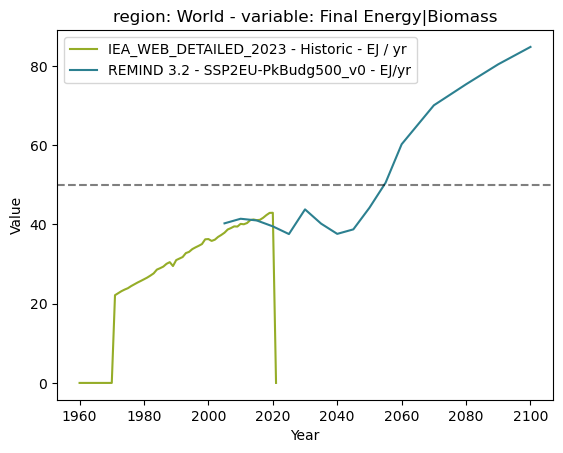

In [18]:
(
    remind_shepherded
    .filter(region = 'World')
    .aggregate(
        'Final Energy|Biomass',
        remind_shepherded.filter(variable='Final*Biomass*').variable
    )
    .plot()
)
plt.axhline(y = 50, color = 'k', linestyle = '--', alpha = 0.5) 

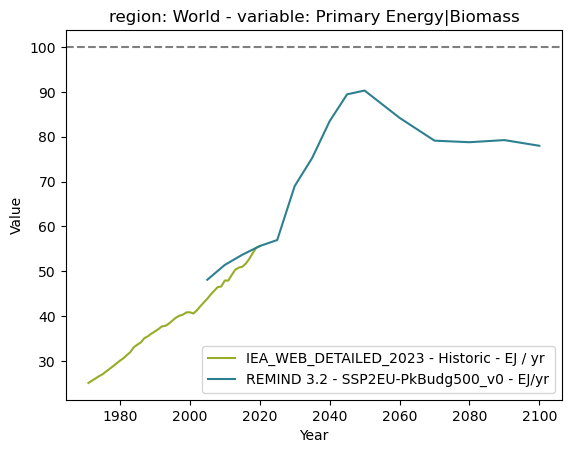

In [19]:
remind_shepherded.filter(region = 'World', variable = 'Primary Energy|Biomass').plot()
plt.axhline(y = 100, color = 'k', linestyle = '--', alpha = 0.5) 

### Check CDR deployment

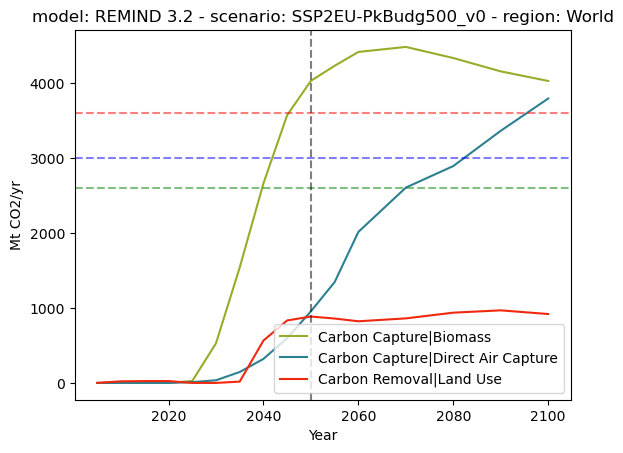

In [25]:
remind_raw.filter(variable = ['Carbon Capture|Biomass', 'Carbon Capture|Direct Air Capture', 'Carbon Removal|Land Use'], region = 'World').plot()
plt.axhline(y = 2600, color = 'green', linestyle = '--', alpha = 0.5) 
plt.axhline(y = 3000, color = 'blue', linestyle = '--', alpha = 0.5) 
plt.axhline(y = 3600, color = 'red', linestyle = '--', alpha = 0.5) 
plt.axvline(x = 2050, color = 'k', linestyle = '--', alpha = 0.5)

BECCS is too high compared to the ideally 2.6 GtCO2/y threshold for 2050

### Transport sector

#### Transport as a whole

In [44]:
def fe_tra(fuel=None):
    if fuel is None:
        return 'Final Energy|Transportation'
    else:
        return f'Final Energy|Transportation|{fuel}'

In [54]:
fe_tra_vars = [fe_tra(fuel) for fuel in ['Electricity','Gases','Hydrogen','Liquids|Biomass','Liquids|Oil and Other']]

In [59]:
color_map = dict(zip(
    fe_tra_vars,
    [ca_colors[n] for n in [3,2,7,6,8]]
))
pyam.run_control().update({'color': {'variable': color_map}})

<Axes: title={'center': 'model: REMIND 3.2 scenario: SSP2EU-PkBudg500_v0 region: World'}, xlabel='Year', ylabel='EJ/yr'>

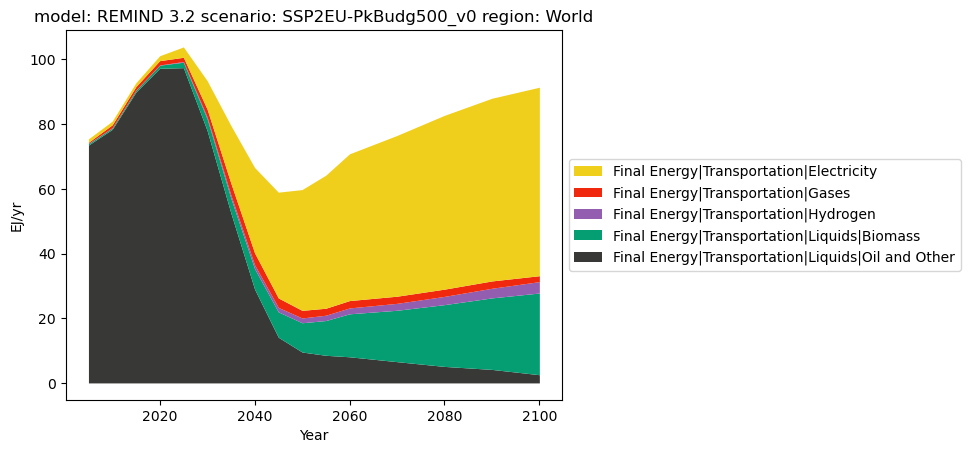

In [60]:
remind_shepherded.filter(variable = fe_tra_vars, region = 'World',model='REMIND 3.2').plot.stack()

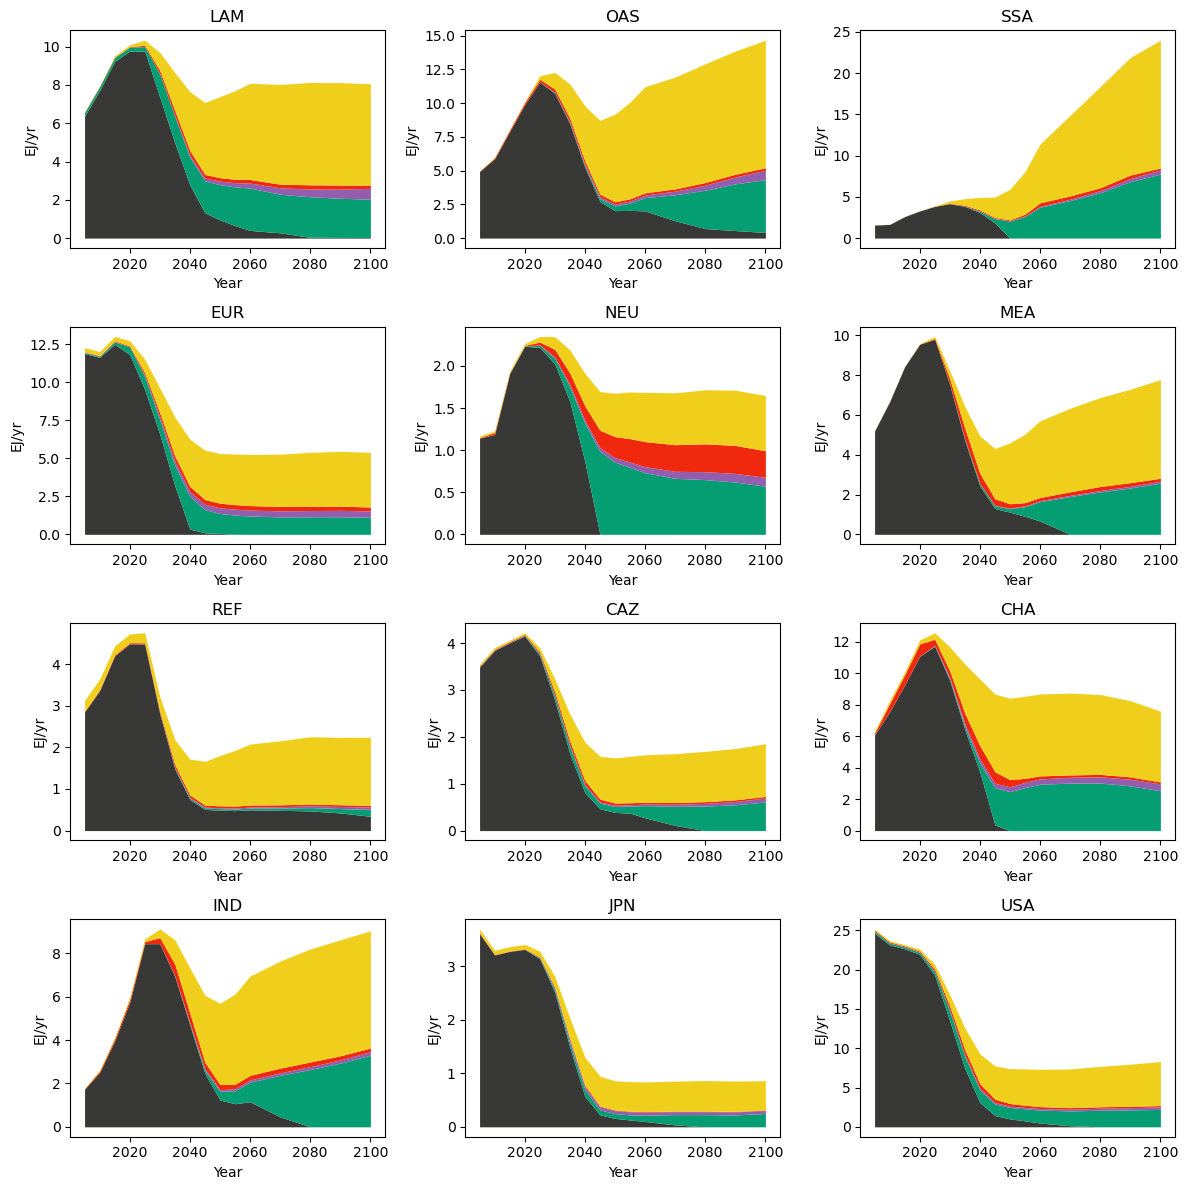

In [61]:
f, axes = plt.subplots(nrows=4,ncols=3,figsize=(12,12))

for count, ax in enumerate(axes.ravel()):
    remind_shepherded.filter(variable = fe_tra_vars, region=model_regions[count],model='REMIND 3.2').plot.stack(ax=ax)
    ax.set_title(model_regions[count])
    ax.get_legend().remove()

# plt.legend()
# axes[0,0].legend(['Coal','Gas'])
plt.tight_layout()

#### LDV sector

In [28]:
tra_ldv_vars = [
    'Final Energy|Transportation|LDV|Electricity',
    'Final Energy|Transportation|LDV|Gases',
    'Final Energy|Transportation|LDV|Hydrogen',
    'Final Energy|Transportation|LDV|Liquids|Biomass',
    'Final Energy|Transportation|LDV|Liquids|Electricity',
    'Final Energy|Transportation|LDV|Liquids|Fossil'
]

In [34]:
ca_colors

[(0.5843137254901961, 0.6784313725490196, 0.1568627450980392),
 (0.17254901960784313, 0.5019607843137255, 0.5647058823529412),
 (0.9411764705882353, 0.1568627450980392, 0.054901960784313725),
 (0.9411764705882353, 0.8117647058823529, 0.10980392156862745),
 (0.0784313725490196, 0.47058823529411764, 0.6901960784313725),
 (0.34901960784313724, 0.788235294117647, 0.32941176470588235),
 (0.0196078431372549, 0.6196078431372549, 0.45098039215686275),
 (0.5803921568627451, 0.3686274509803922, 0.6901960784313725),
 (0.2196078431372549, 0.2196078431372549, 0.21176470588235294),
 (0.5098039215686274, 0.5098039215686274, 0.5098039215686274),
 (0.7607843137254902, 0.7607843137254902, 0.7607843137254902)]

In [37]:
color_map = dict(zip(
    tra_ldv_vars,
    [ca_colors[n] for n in [3,2,7,6,4,8]]
))
pyam.run_control().update({'color': {'variable': color_map}})

<Axes: title={'center': 'model: REMIND 3.2 scenario: SSP2EU-PkBudg500_v0 region: World'}, xlabel='Year', ylabel='EJ/yr'>

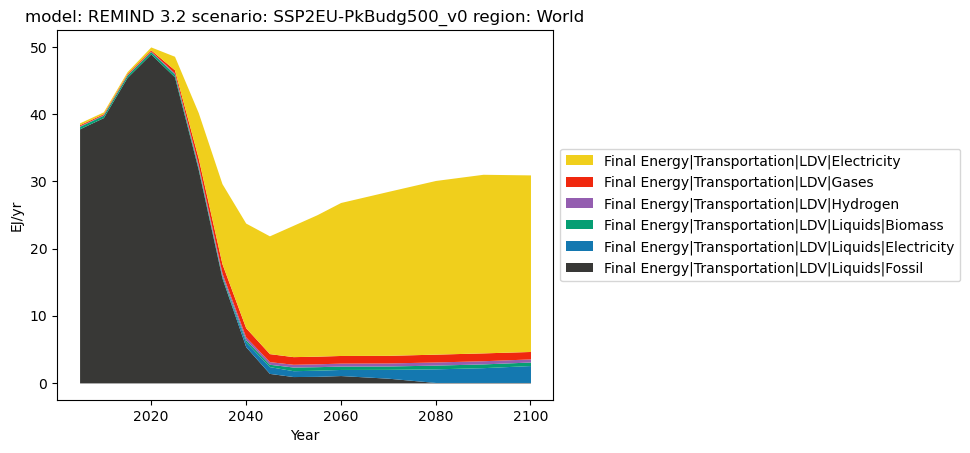

In [38]:
remind_raw.filter(variable = tra_ldv_vars, region = 'World').plot.stack()

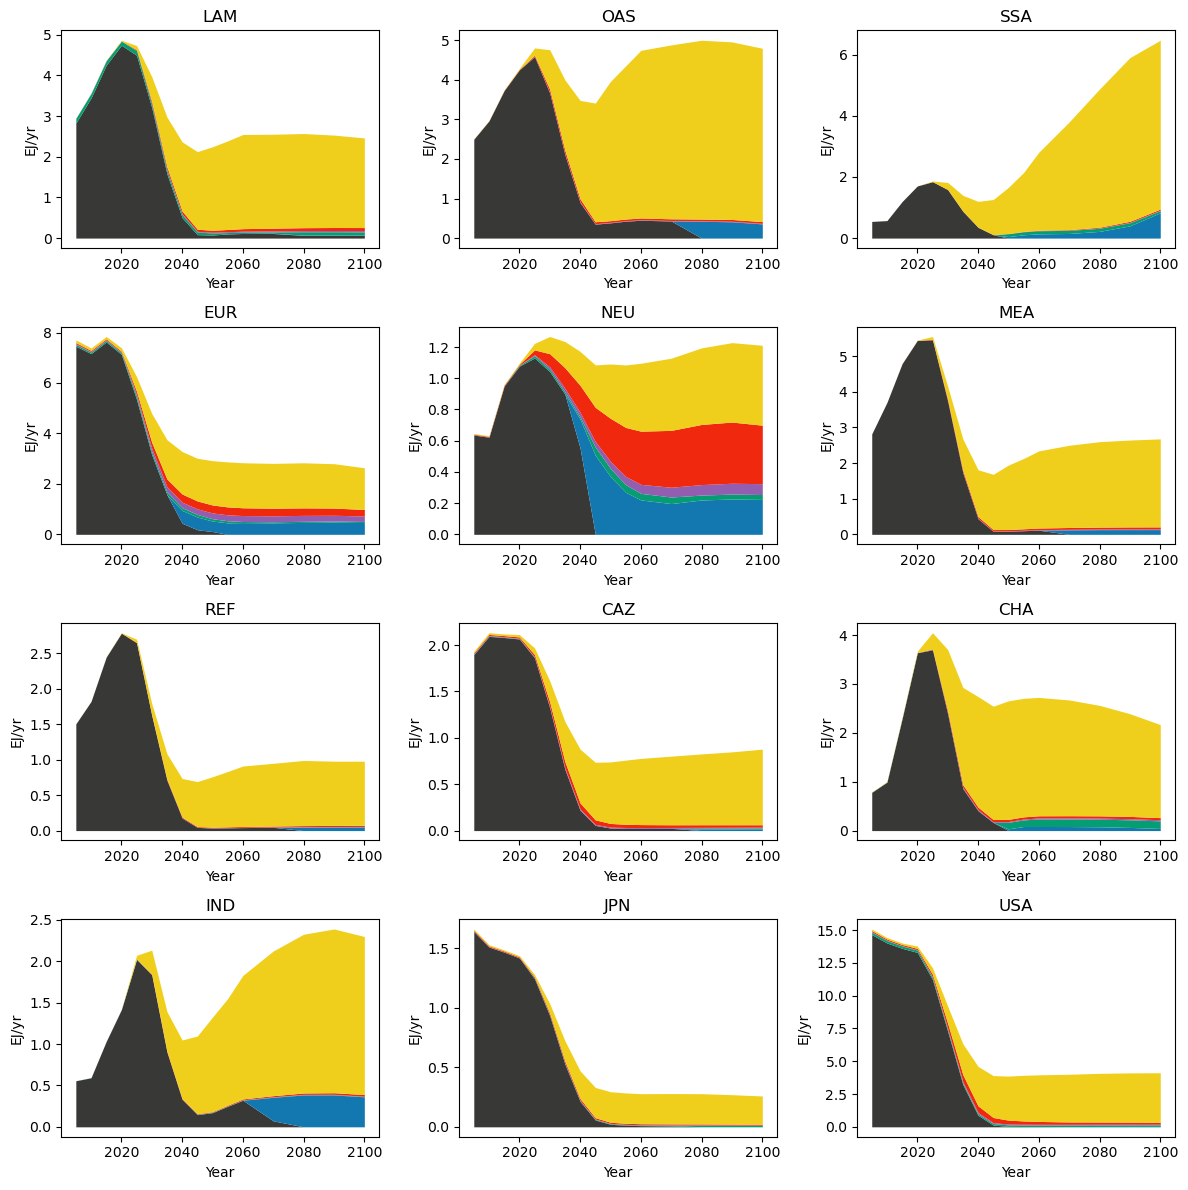

In [39]:
f, axes = plt.subplots(nrows=4,ncols=3,figsize=(12,12))

for count, ax in enumerate(axes.ravel()):
    remind_raw.filter(variable = tra_ldv_vars, region=model_regions[count]).plot.stack(ax=ax)
    ax.set_title(model_regions[count])
    ax.get_legend().remove()

# plt.legend()
# axes[0,0].legend(['Coal','Gas'])
plt.tight_layout()

Want ideally an entire shift to electricity in LDV -> need to push harder on this